In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score

from synexp import *
from viz import *


/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

- $X \in [-1, 1]$ is a unidimensional co-variate
- Target potential outcome (PO) class probabilities $\eta^*_0(x), \eta^*_1(x)$ are piecewise sinusoidal functions satisfying weak seperability

- $\pi(x)=.2 x +.4$ is linear and correlated with $\eta^*_0(x)$. Specifically, cases at high risk under no intervention are also most likely to receive intervention

- Error parameters sampled randomly $\alpha_d, \beta_d \sim U(.01,.24)$

<!-- 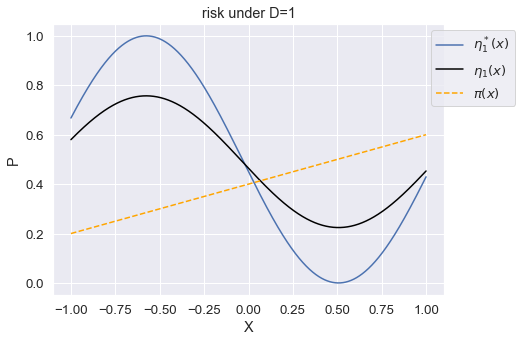 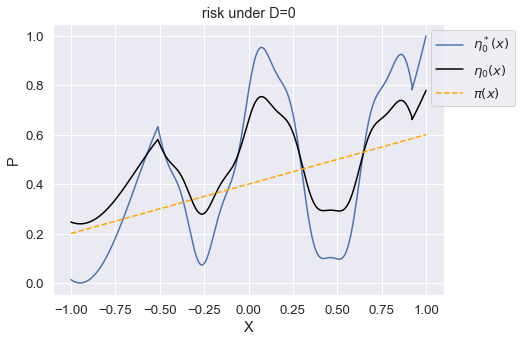  -->

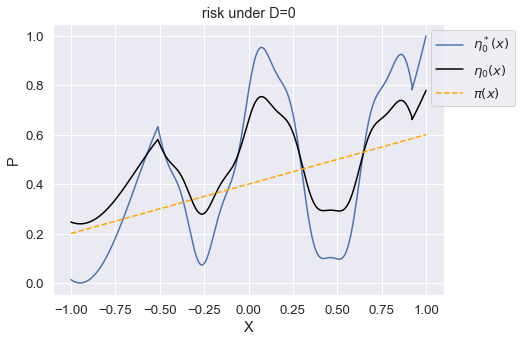
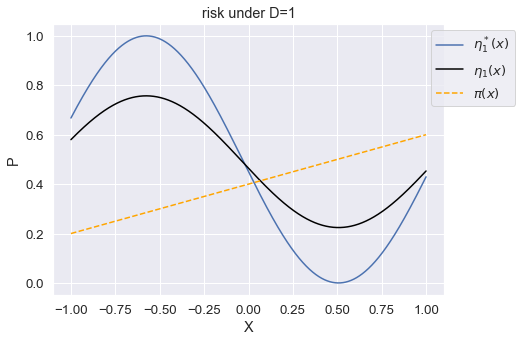

 
### Data generating process:

1. $Y^*_0, Y^*_1 \sim $ Bern($\eta^*_0(x)$), Bern($\eta^*_1(x)$), $\forall x \in X$
2. Sample errors $\alpha_d, \beta_d \sim U(.01,.24) \forall d \in D$
3. Flip $Y^*_d$, $Y^*_1$ based errors on $\alpha_d, \beta_d \forall d \in D$
4. Sample $D=d$ from $Bern(pi(x))$, $\forall x \in X$
5. Observe potential outcomes $Y=Y_0(1-D) + Y_1(D)$, $Y^*=Y_0^*(1-D) + Y_1^*(D)$

## Experiments


#### Model comparision
- $\hat{P}[Y=1|X=x]$ (observational)
- $\hat{P}_{\ell}[Y=1|D=d,X=x]$ (conditional outcome)
- $\hat{P}_{\tilde{\ell}}[Y=1|D=d,X=x]$ (**ours:** conditional outcome with surrogate loss)
- $\hat{P}[Y_d=1|X=x]$ (proxy PO oracle)
- $\hat{P}[Y^*_d=1|X=x]$ (target PO oracle)

Metrics: 
- Accuracy, AU-ROC, FPR/FNR w.r.t $Y^*_d$

#### Parameter estimation experiment (test of CCPE approach)
- Plot parameter estimation error as a function of sample size
- Show more estimation error in $\beta_0$ term when D non-random ($\pi$ non-uniform)

#### Robustness to parameter estimation error
- Performance of surrogate loss as a functon of parameter estimation error








In [17]:
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'

# Example code invoking experiemnt setup functions
expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.24,
    error_max=0.25
)
# Sanity check
# results, val_scores = run_baseline_comparison_exp(expdf, do=0,
#                                            error_params=error_params, n_epochs=20, train_ratio=.7)

## Main Experiment: Validating factual surrogate loss correction

In [22]:
do=0
baselines = [{
    'model': 'Observational',
    'target': 'Y0'
},{
    'model': 'Conditional outcome',
    'target': 'Y0'
},{
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
},{
    'model': 'Proxy PO Oracle',
    'target': f'Y0_{do}'
},{
    'model': 'Target PO Oracle',
    'target': f'YS_{do}'
}]

# Run this during the meeting #
exp_results = run_baseline_comparison_exp(baselines, do=do,
                                          N_RUNS=2, NS=5000, K=1, n_epochs=10)
resultdf = pd.DataFrame(exp_results)
resultdf.to_csv('results/exp1_results.csv', index=False)



Target: YS_0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


Text(0.5, 0, '')

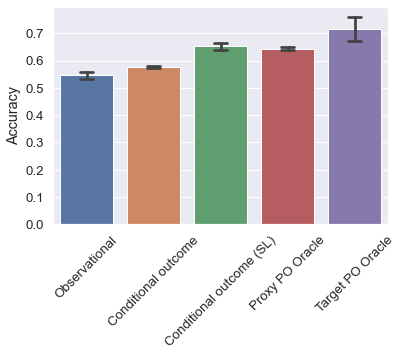

In [23]:
sns.set(font_scale=1.2)
g=sns.barplot(data=resultdf, x='model', y='ACC', capsize=.2)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('')

Text(0.5, 0, '')

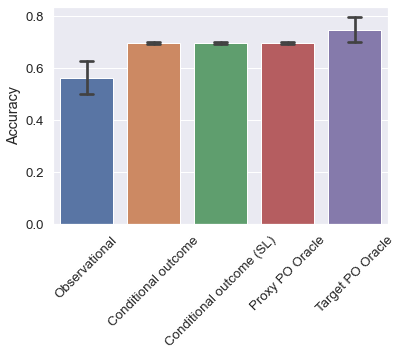

In [24]:
sns.set(font_scale=1.2)
g=sns.barplot(data=resultdf, x='model', y='AU-ROC', capsize=.2)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('')

In [25]:
resultdf.groupby('model').mean()

,AU-ROC,ACC
model,,
Conditional outcome,0.696755,0.577000
Conditional outcome (SL),0.696703,0.652000
Observational,0.564345,0.545667
Proxy PO Oracle,0.696648,0.644000
Target PO Oracle,0.748099,0.714333


## Main Experiment: parameter estimation via CCPE

In [ ]:
SAMPLE_SIZES = [1000, 5000, 10000, 20000]
exp_results, py_results = ccpe_benchmark_exp(SAMPLE_SIZES, N_RUNS=5, K=3, n_epochs=20)
result_df = get_ccpe_result_df(do=1, exp_results=exp_results)


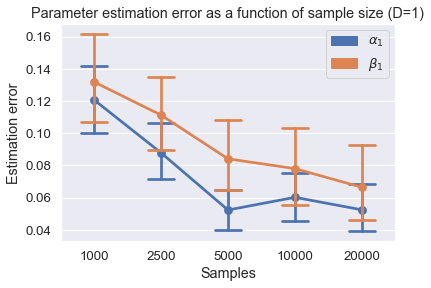

In [62]:
result_df = pd.read_csv('results/R3_K=5,N_RUNS=20,n_epochs=40_d1.csv')
result_df = result_df[result_df['aggregate'] == False]
g = sns.pointplot(
    data=result_df,
    x='NS',
    y='error',
    hue='parameter',
    capsize=.4,
    legend=True
)
g.set(xlabel='Samples', ylabel='Estimation error',
      title='Parameter estimation error as a function of sample size (D=1)')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color=sns.color_palette()[0], label=r'$\alpha_1$')
black_patch = mpatches.Patch(color=sns.color_palette()[1], label=r'$\beta_1$')
plt.legend(handles=[red_patch, black_patch])


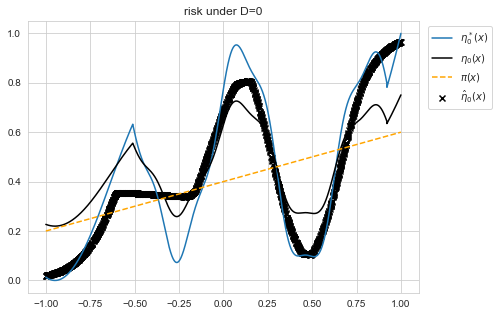

In [25]:
do=0
debug_info = {
    'val_x': results2['x'],
    'val_py': results2['py_hat']
}
viz_ccpe_estimates(expdf, debug_info, error_params[f'alpha_{do}'][0],
                   error_params[f'beta_{do}'][0], do, Y0_PDF, Y1_PDF, PI_PDF)


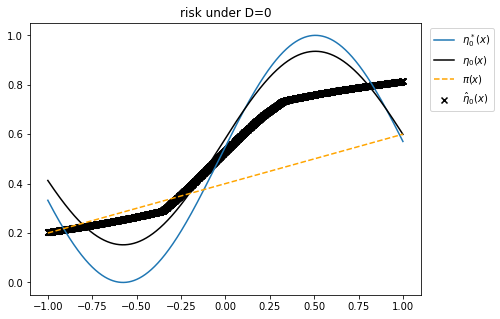

In [114]:
# Possibly create a helper function here for plotting resuls of experiments

params = { 'alpha': None, 'alpha_0': 0.15228761, 'beta': None, 'beta_0': 0.06452641 }

do=0
debug_info = {
    'val_x': py_results[8000][0][0][0]['x'],
    'val_py': py_results[8000][0]['eta_0_bar']
}
expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.05,
    error_max=0.25
)

viz_ccpe_estimates(expdf, debug_info, params, do, Y0_PDF, Y1_PDF, PI_PDF)


## Experiment: Robustness to Estimation Error

In [9]:
alphas = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45]
betas = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45]

error_mag = [0.001, .01, .05, .1, .2]

configs = []

for alpha in alphas:
    for beta in betas:
        for error in error_mag:
            if alpha+beta < .5:
                configs.append({
                    'alpha_true': alpha,
                    'beta_true': beta,
                    'alpha_hat': error
                    'beta_hat': error
                })
        


In [ ]:
alpha, beta, error

if 

num-error > 0 and num

In [11]:
len(configs)

385

In [5]:
expdf, error_params = generate_syn_data(
    NS=10000,
    K=5,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.095,
    error_max=0.105,
    shuffle=True
)

params = [{
    'alpha': .1,
    'beta': .1
},{
    'alpha': .1,
    'beta': .3
},{
    'alpha': .2,
    'beta': .2
},{
    'alpha': .2,
    'beta': .4
},{
    'alpha': .05,
    'beta': .4
}]
baseline = {
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
}

results = []
for param in params:
    results.append(run_baseline(expdf, baseline, do=0, surrogate_params=param, n_epochs=5, train_ratio=.7))





Target: Y0:   0%|                                                                                                                                  | 0/5 [00:00<?, ?it/s]

0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1



Target: Y0:  20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:03,  1.14it/s]

0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1



Target: Y0:  40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:01<00:02,  1.16it/s]

0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1



Target: Y0:  60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:02<00:01,  1.16it/s]

0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1



Target: Y0:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:03<00:00,  1.18it/s]

0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1


Target: Y0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.18it/s]

0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1
0.1 0.1



Target: Y0:   0%|                                                                                                                                  | 0/5 [00:00<?, ?it/s]

0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3



Target: Y0:  20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:03,  1.28it/s]

0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3



Target: Y0:  40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:01<00:02,  1.27it/s]

0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3



Target: Y0:  60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:02<00:01,  1.26it/s]

0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3



Target: Y0:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:03<00:00,  1.26it/s]

0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3


Target: Y0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]

0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3
0.1 0.3



Target: Y0:   0%|                                                                                                                                  | 0/5 [00:00<?, ?it/s]

0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2



Target: Y0:  20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:03,  1.27it/s]

0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2



Target: Y0:  40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:01<00:02,  1.22it/s]

0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2



Target: Y0:  60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:02<00:01,  1.23it/s]

0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2



Target: Y0:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:03<00:00,  1.24it/s]

0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2


Target: Y0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.25it/s]

0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2
0.2 0.2



Target: Y0:   0%|                                                                                                                                  | 0/5 [00:00<?, ?it/s]

0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4



Target: Y0:  20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:03,  1.28it/s]

0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4



Target: Y0:  40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:01<00:02,  1.28it/s]

0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4



Target: Y0:  60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:02<00:01,  1.28it/s]

0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4



Target: Y0:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:03<00:00,  1.28it/s]

0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4


Target: Y0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4
0.2 0.4



Target: Y0:   0%|                                                                                                                                  | 0/5 [00:00<?, ?it/s]

0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0


Target: Y0:  20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:03,  1.28it/s]

0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0


Target: Y0:  40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:01<00:02,  1.27it/s]

0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0


Target: Y0:  60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:02<00:01,  1.27it/s]

0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0


Target: Y0:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:03<00:00,  1.27it/s]

0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0

Target: Y0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.27it/s]

0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4
0.05 0.4


In [8]:
params = [{
    'alpha': .1,
    'beta': .1
},{
    'alpha': .1,
    'beta': .3
},{
    'alpha': .2, #actual values#
    'beta': .2
},{
    'alpha': .2,
    'beta': .4
},{
    'alpha': .05,
    'beta': .4
}]
t = [result['ACC'] for result in results]
t

[0.638, 0.5623333333333334, 0.647, 0.5346666666666666, 0.5116666666666667]

In [7]:
surrogate_params

NameError: name 'surrogate_params' is not defined

In [16]:
expdf, error_params = generate_syn_data(
    NS=NS,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.05,
    error_max=0.25
)

In [ ]:
def get_noisy_params(true_params, do, eps):
    
    alpha_true = error_params[f'alpha_{do}']
    beta_true = error_params[f'beta_{do}']
    random.sample([-1, 1], 1)[0] * eps
    

In [11]:
Y0_PDF = 'sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'


baseline = {
    'model': 'Conditional outcome (SL)',
    'target': 'Y0'
}
        
exp_results = {
    'model': [],
    'AU-ROC': [],
    'ACC': []
}

for config in param_configs:
    
    for RUN in range(N_RUNS):
        expdf, error_params = generate_syn_data(
            NS,
            K,
            y0_pdf=Y0_PDF,
            y1_pdf=Y1_PDF,
            pi_pdf=PI_PDF,
            error_min=0.05,
            error_max=0.25
        )
        
        target = baseline['target']

        run_baseline(expdf, baseline, do, surrogate_params, n_epochs=5, train_ratio=.7)


NameError: name 'param_configs' is not defined

In [ ]:
def run_estimation_error_exp(expdf, do, error_params, n_epochs=5, train_ratio=.7):

    expdf = expdf.sample(frac=1).reset_index(drop=True)
    split_ix = int(expdf.shape[0]*train_ratio)
    train_df, val_df = expdf.iloc[:split_ix,:], expdf.iloc[split_ix:,:]
    
    exp_results = {
        'noise_rate': [],
        'AU-ROC': []
    }


    
    targets = ['YD']
    val_scores = {}
    
    for surrogate_params in param_configs:
        
        train_loader, val_loader = get_loaders(train_df, val_df, do, target)
        model = MLP()
        losses = train(model, train_loader, error_params=surrogate_params, n_epochs=n_epochs)
        x, y, py_hat = evaluate(model, val_loader)
        auroc = roc_auc_score(y, py_hat)

        exp_results['noise_rate'].append(surrogate_params['alpha']+surrogate_params['beta'])
        exp_results['AU-ROC'].append(auroc)
        
        val_scores[target] = {}
        val_scores[target]['x'] = x
        val_scores[target]['y'] = y
        val_scores[target]['py_hat'] = py_hat

    return exp_results, val_scores

run_estimation_error_exp(expdf, do, error_params,
                         n_epochs=5, train_ratio=.7)

sns.barplot(data=resultdf, x='model', y='AU-ROC')

## Visualize class probability estimates

Target: YS_0: 100%|█████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


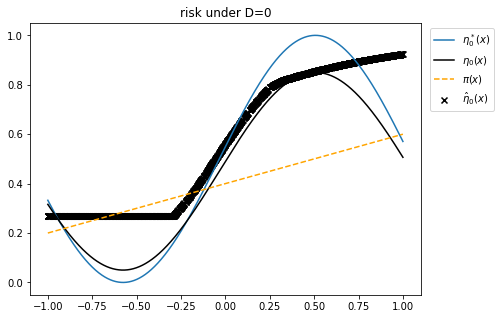

In [19]:
params = { 'alpha': None, 'alpha_0': .05, 'beta': None, 'beta_0': .15 }
baseline = {
    'model': 'Target PO Oracle',
    'target': 'YS_0'
    
}

results = run_baseline(expdf, baseline, do, params,
             n_epochs=10, train_ratio=.7)

do=0
debug_info = {
    'val_x': results['x'],
    'val_py': results['py_hat']
}

viz_ccpe_estimates(expdf, debug_info, params, do, Y0_PDF, Y1_PDF, PI_PDF)


### Debugging baselines

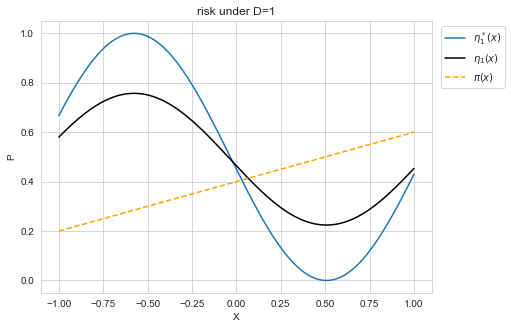

In [2]:
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'
do=1

expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.20,
    error_max=0.25
)

debug_info = {
    'val_x': None,
    'val_py': None
}

viz_ccpe_estimates(expdf, debug_info, error_params[f'alpha_{do}'][0],
                   error_params[f'beta_{do}'][0], do, Y0_PDF, Y1_PDF, PI_PDF)

In [3]:
## Main Experiment: troubleshoot baselines

Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'
do=0

expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.20,
    error_max=0.25
)
expdfshuffled = expdf.sample(frac=1).reset_index(drop=True)
baseline1 = {
    'model': 'Proxy PO Oracle',
    'target': f'Y0_{do}'
}

baseline2 = {
    'model': 'Target PO Oracle',
    'target': f'YS_{do}'
}

surrogate_params = {
    'alpha': None,
    'beta': None
}

results1 = run_baseline(expdfshuffled, baseline1, do, surrogate_params, n_epochs=10, train_ratio=.7)
results2 = run_baseline(expdfshuffled, baseline2, do, surrogate_params, n_epochs=10, train_ratio=.7)



Target: Y0_0:  30%|███████████████████████████████████▋                                                                                   | 3/10 [00:02<00:06,  1.05it/s]  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.9/3.9.8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/local/Cellar/python@3.9/3.9.8/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/torch/__init__.py", line 721, in <module>
    _C._initExtension(manager_path())
  File "/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/torch/cuda/__init__.py", line 759, in <module>
    from . import amp
  File "/Users/lguerdan/.virtualenvs/10701-Project/lib/python3.9/site-packages/torch/cuda/amp/__init__.p

RuntimeError: DataLoader worker (pid 69744) is killed by signal: Interrupt: 2. 

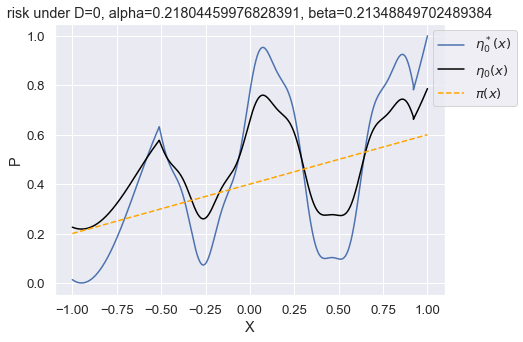

In [2]:
Y0_PDF = 'piecewise_sinusoid'
Y1_PDF = 'low_base_rate_sinusoid'
PI_PDF = 'linear'
do=0

expdf, error_params = generate_syn_data(
    NS=5000,
    K=1,
    y0_pdf=Y0_PDF,
    y1_pdf=Y1_PDF,
    pi_pdf=PI_PDF,
    error_min=0.20,
    error_max=0.25
)
debug_info = {
    'val_x': None,
    'val_py': None
}
sns.set(font_scale=1.2)
viz_ccpe_estimates(expdf, debug_info, error_params[f'alpha_{do}'][0],
                   error_params[f'beta_{do}'][0], do, Y0_PDF, Y1_PDF, PI_PDF)
